In [1]:
import numpy as np
import pandas as pd
from shapely import centroid
import os
import shutil

# Note from the future
This notebook contains early EDA back when the project was more aligned with the persistent cohomology paper. We ended up pivoting away from that paper due to questions about the relevancy of the data and inability to determine provenance of some data pieces (e.g. were the polling locations in Chicago from before or after the redistricting)

# Chicago Precinct Maps

Found map of Chicago Precincts for 2012-2022 [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Ward-Precincts-2012-2022-/uvpq-qeeq). Data saved as csv [here](../project_data/chc/ChicagoPrecincts2012_2022.csv)

In [2]:
from shapely import MultiPolygon, Polygon, wkt, intersection
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Get data into geopandas format, shapely objects instead of strings

In [3]:
precs = pd.read_csv('../project_data/chc/ChicagoPrecincts2012_2022.csv')

In [4]:
precs['the_geom'] = precs['the_geom'].apply(wkt.loads)
precs = precs.rename(columns={'the_geom':'geometry'})

In [5]:
precs = gpd.GeoDataFrame(precs, crs='epsg:4326')


geopandas has nice plotting function that looks for a "geometry" column

<Axes: >

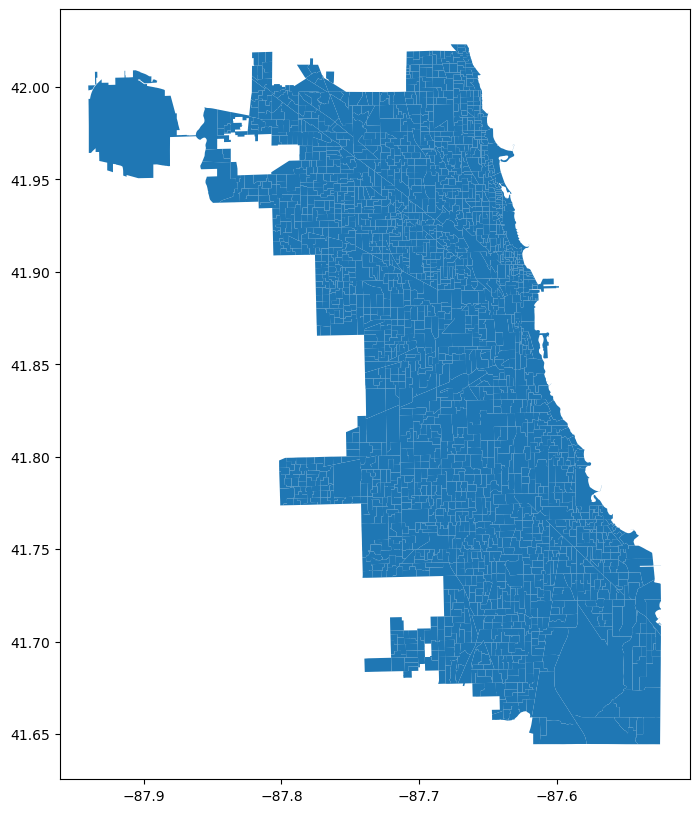

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax)


### Map together with death simplices

In [7]:
dsimp_data = np.load('../project_data/chc/chc_death_simplices_by_death_in_dim_1.npy', allow_pickle=True)
dsimp_dict = dict(zip(['geometry','death_filtration_value','death_filtration_zscore','death_birth_ratio'],dsimp_data.T))
dsimps = pd.DataFrame(dsimp_dict)
dsimps = gpd.GeoDataFrame(dsimps, crs='epsg:4326')

<Axes: >

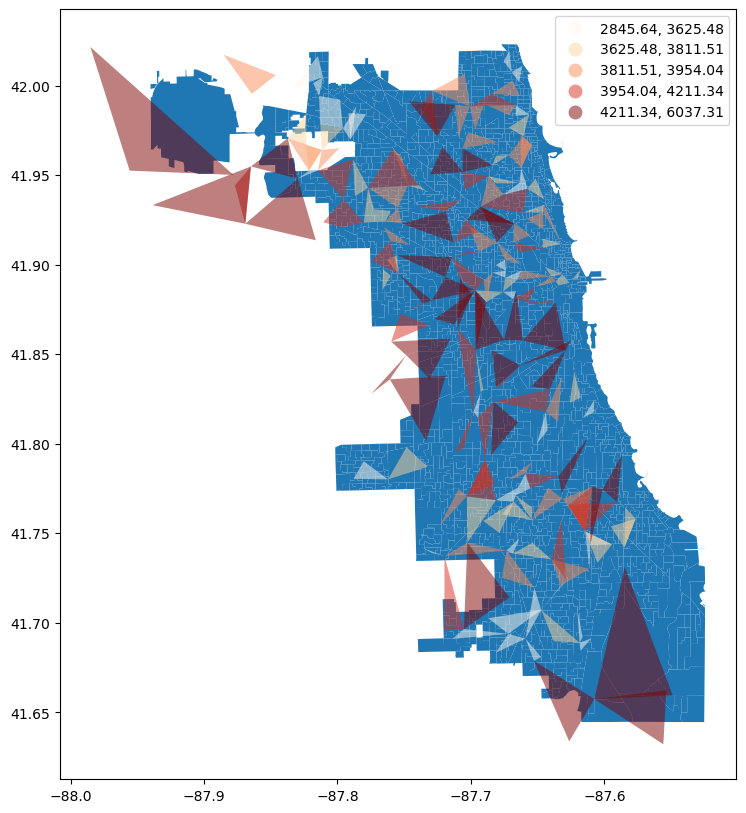

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax)
dsimps.plot(alpha=.5,ax=ax,column='death_filtration_value',
                                         cmap='OrRd',legend=True,scheme='quantiles')

Something to keep in mind is that the paper makes a cut at death_birth_ratio=1.05 to filter out artifacts

In [9]:
dsimps = dsimps[dsimps.death_birth_ratio>=1.05]

<Axes: >

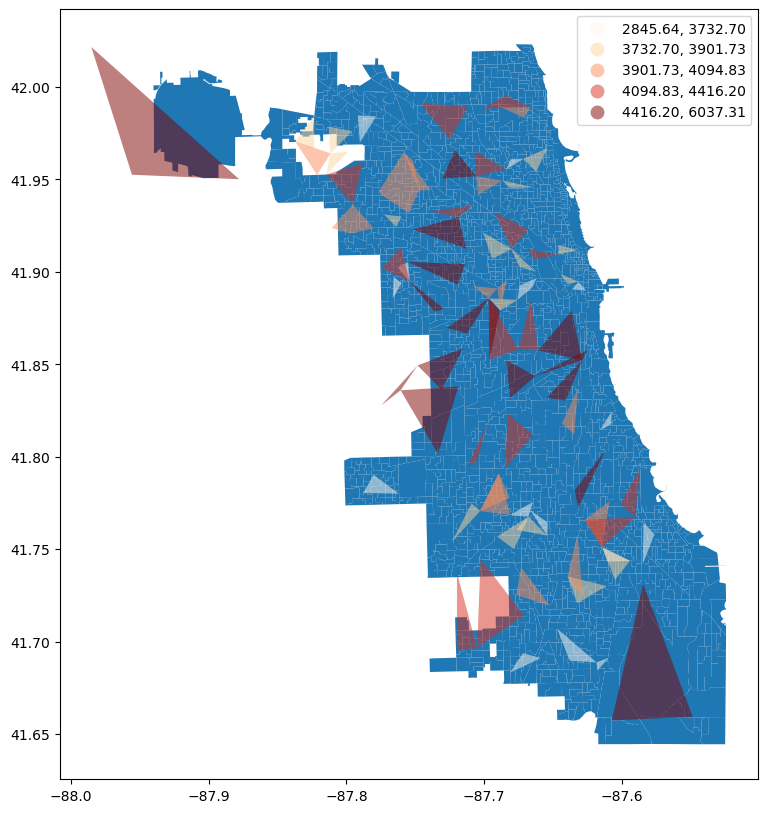

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax)
dsimps.plot(alpha=.5,ax=ax,column='death_filtration_value',
                                         cmap='OrRd',legend=True,scheme='quantiles')

### Check which precincts overlap with which death simplices

In [11]:

n_intersect = []
mean_dfv = []
area_intersect = []
for ii, prec in precs.iterrows():
    dfvs_ii = []
    dsimps_ii = []
    areas_ii = []
    
    for jj, dsimp in dsimps.iterrows():

        if not intersection(prec.geometry,dsimp.geometry).area == 0:
            
            dsimps_ii.append(jj)
            dfvs_ii.append(dsimp.death_filtration_value)
            
    if len(dfvs_ii) == 0:
        mean_dfv.append(0)
    else:
        mean_dfv.append(np.mean(dfvs_ii))
                        
    n_intersect.append(len(dsimps_ii))


precs['n_intersect'] = n_intersect
precs['mean_dfv'] = mean_dfv


#### Precincts by # of intersections with death simplex

Text(0.5, 1.0, 'Chicago Voting Precincts and Simplex Overlap')

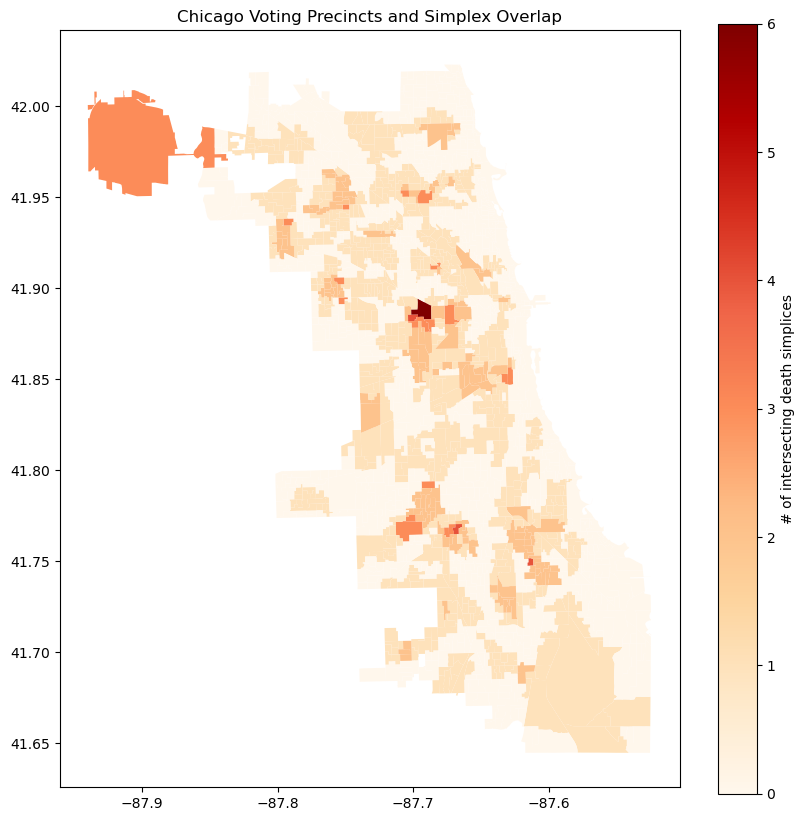

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax,column='n_intersect',cmap='OrRd',legend=True,legend_kwds={"label": "# of intersecting death simplices"})
ax.set_title('Chicago Voting Precincts and Simplex Overlap')

#### Precincts by average intersecting death filtration value

<Axes: >

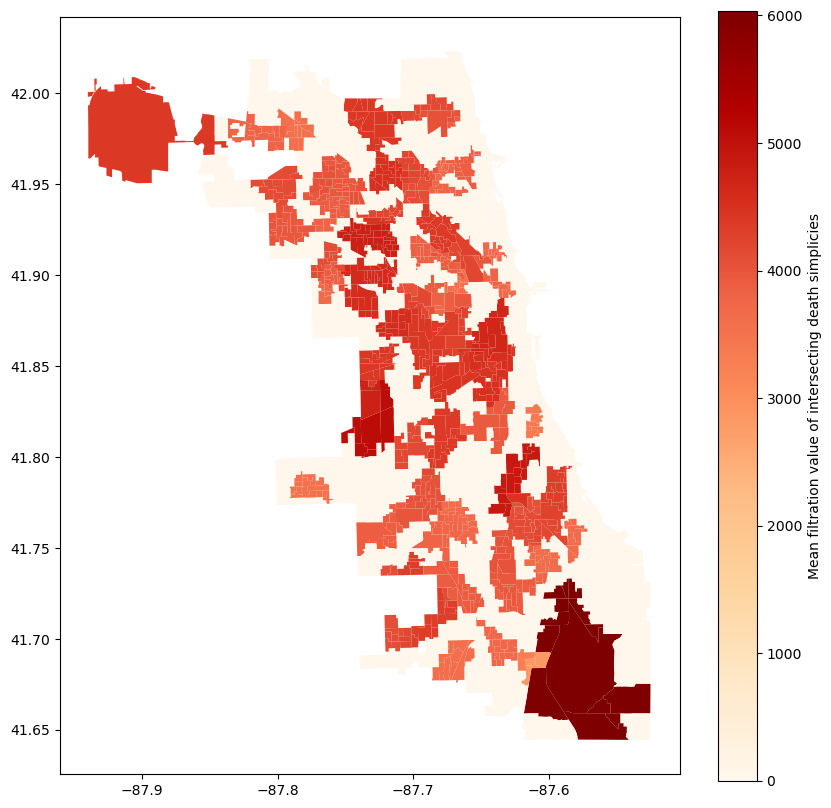

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
precs.plot(ax=ax,column='mean_dfv',cmap='OrRd',legend=True,legend_kwds={"label": "Mean filtration value of intersecting death simplicies"})


In [166]:
import seaborn as sns

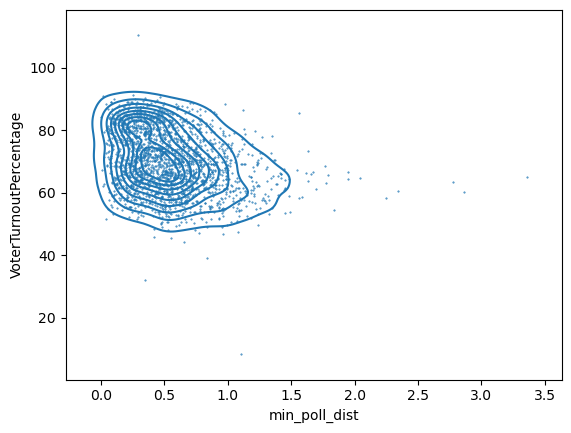

In [168]:
sns.kdeplot(data=precs, x="min_poll_dist", y="VoterTurnoutPercentage")
plt.scatter(precs.min_poll_dist,precs.VoterTurnoutPercentage,s=.2)


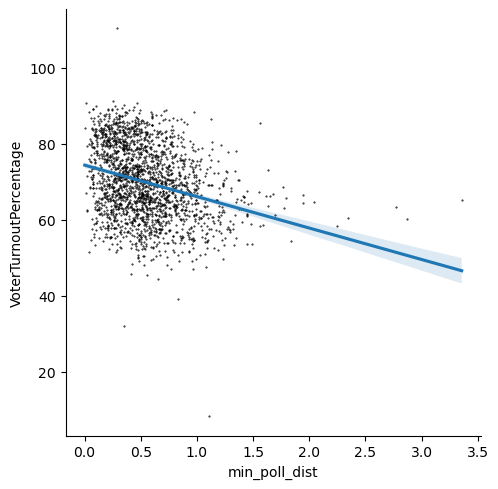

In [175]:
sns.lmplot(data=precs, x="min_poll_dist", y="VoterTurnoutPercentage",scatter=False)
plt.scatter(precs.min_poll_dist,precs.VoterTurnoutPercentage,s=.2,color='k')
